# This script generates snow components for different snow products

In [4]:
from netCDF4 import Dataset
import pickle
import xarray as xr
from cartoplot import cartoplot
import mask
from field_importer import get_field
from scipy.interpolate import NearestNDInterpolator
import scipy.interpolate
from field_importer import get_field
# from mask import select_region, punch_lat_hole
import numpy.ma as ma
# from select_type import select_type
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import trange
from regrid import regrid
%config Completer.use_jedi = False

/home/robbie/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [6]:
yearlist = list(range(2020,2022))
print(yearlist)

monthlist_full = ["01","02","03","04","10","11","12"]
monthlist_end = ["01","02","03","04"]
monthlist_start = ["10","11","12"]

[2020, 2021]


# Calculate components

In [7]:
resolution = (361,361)
snow_factor = 0.001813

def components(include_E5=True):
    
    for year in yearlist: # Do not modify - chage yearlist itself!

        print(year)

        if year == 2002:
            monthlist = monthlist_start
        elif year == 2021:
            monthlist = monthlist_end
        else:
            monthlist = monthlist_full
        
        nan_array = np.full((len(monthlist),resolution[0],resolution[1]), np.nan)
        
        mW99_conts = nan_array.copy()
        SM_conts = nan_array.copy()
        M2_conts = nan_array.copy()
        E5_conts = nan_array.copy()
        NS_conts = nan_array.copy()
        freeboard_conts = nan_array.copy()
        freeboard_adj_conts = nan_array.copy()
        types = nan_array.copy()

        for counter, month in enumerate(monthlist):

            
#             mW99_SWE = get_field('mW99',month,year,resolution=361,variable='SWE')['field']
            M2_SWE = get_field('SnowModel',month,year,resolution=361,variable='M2 SWE')['field']
            
#             if include_E5:
#                 SM_SWE = get_field('SnowModel',month,year,resolution=361,variable='SWE')['field']
#                 E5_SWE = get_field('SnowModel',month,year,resolution=361,variable='E5 SWE')['field']
            
#             if (year < 2015) or (year == 2015 and int(month) < 5):
#                 NS_SWE = get_field('nesosim',month,year,resolution=361,variable='swe')['field']
                
                
            type_type= 'cds'
#             if int(year) < 2005:
#                 type_type = 'cds'
#             elif (int(year) == 2005) and (int(month) < 6):
#                 type_type = 'cds'
#             else:
#                 type_type = 'osisaf'
                
        
            if int(year) < 2010:
                radar_type = 'cci_envisat'
            elif (int(year) == 2010) and (int(month)<11):
                radar_type = 'cci_envisat'
            elif int(year) < 2017:
                radar_type = 'cci_cs2'
            elif (int(year) == 2017) and (int(month) < 5):
                radar_type = 'cci_cs2'
            else:
                radar_type = 'awi_cs2'
                
            ice_type = get_field(type_type,month,year,resolution=361,variable='type')['field']
            
            radar_freeboard_data = get_field(radar_type,month,year,resolution=361,variable='rad')

            radar_freeboards = regrid(radar_freeboard_data['field'],
                                       radar_freeboard_data['lon'],
                                       radar_freeboard_data['lat'],
                                       mask.get('lon'),
                                       mask.get('lat'),
                                       )
            
            if 'envisat' in radar_type:
            
                FYI_contribution = select_type('fyi', radar_freeboards, year, month)-0.025
                MYI_contribution = select_type('myi', radar_freeboards, year, month)+0.025
                recombined = np.nansum(np.dstack((FYI_contribution,MYI_contribution)),2)
                recombined = select_type('all', recombined, year, month)
                rf_adjusted = punch_lat_hole(recombined, latitude=88.5)
                
            else:
                rf_adjusted = punch_lat_hole(radar_freeboards, latitude=88.5)
            
            ########################################################################
            
            # Make mW99 contribution
            
            rho_w   = 1023.9
            rho_fyi = 916.7
            rho_myi = 882
            
            nans_everywhere = np.full(  (resolution), np.nan)
            
            MYI_masked = ma.masked_where(ice_type == 3, nans_everywhere)
            MYI_masked = np.ma.filled(MYI_masked.astype(float), rho_myi)
            
            FYI_masked = ma.masked_where(ice_type == 2, MYI_masked)
            density_field = np.ma.filled(FYI_masked.astype(float), rho_fyi)
            
            hydro_coeff_field = np.divide(rho_w, np.subtract(rho_w,density_field))

            snow_coeff_field = np.multiply(snow_factor,hydro_coeff_field)

            mW99_conts[counter] = np.multiply(mW99_SWE, snow_coeff_field)
            
            #####################################################################################
            
            # Make SM contribution
            
            if include_E5:
                SM_conts[counter] = np.multiply(SM_SWE, snow_coeff_field)
                E5_conts[counter] = np.multiply(E5_SWE, snow_coeff_field)
            
            M2_conts[counter] = np.multiply(M2_SWE, snow_coeff_field)
            
            # Make NS contribution
            
            if (year < 2015) or (year == 2015 and int(month) < 5):
                NS_conts[counter] = np.multiply(NS_SWE, snow_coeff_field)
            
            ######################################################################################
            
            # Make Radar Freeboard Contribution
    
            temp_fb = np.multiply(hydro_coeff_field,radar_freeboards)
            temp_fb_adj = np.multiply(hydro_coeff_field,rf_adjusted) 
        
            # Fix November 2009 RF anomaly in Barents Sea
        
            if (month == "11") and (year == 2009):
                mask_field = mask.get('mask')
                temp_fb = ma.masked_where(mask_field == 8, temp_fb)
                temp_fb = np.ma.filled(temp_fb.astype(float), np.nan)
                
                temp_fb_adj = ma.masked_where(mask_field == 8, temp_fb_adj)
                temp_fb_adj = np.ma.filled(temp_fb_adj.astype(float), np.nan)
                print('Fixed Barents 09/2009 coastal anomaly')
                
            freeboard_conts[counter] = temp_fb
            freeboard_adj_conts[counter] = temp_fb_adj
            
            ######################################################################################
            
            # Save Ice Type
            
            types[counter] = ice_type

        # SAVE THE YEAR'S DATA AS NETCDF

        monthlist_ints = [int(month) for month in monthlist]
        
        data_vars = {'mW99':(['t','x','y'],mW99_conts),
#                     'SM':(['t','x','y'],SM_conts),
                    'M2':(['t','x','y'],M2_conts),
#                     'E5':(['t','x','y'],E5_conts),                     
                    'free':(['t','x','y'],freeboard_conts),
                    'free_adj':(['t','x','y'],freeboard_adj_conts),
                    'type':(['t','x','y'],types)       }
        
        if include_E5:
            data_vars['SM'] = (['t','x','y'],SM_conts)
            data_vars['E5'] = (['t','x','y'],E5_conts)
        
        if year < 2016:
            data_vars['NS'] = (['t','x','y'],NS_conts)



        ds = xr.Dataset(data_vars = data_vars,
                        
                        coords={'lon':(['x','y'],mask.get('lon')),
                                 'lat':(['x','y'],mask.get('lat')),
                                 'month':(['t'],monthlist_ints)}    )

        data_dir = '/home/robbie/Dropbox/SM_Thickness/data/Components/'
        
        ds.to_netcdf(f'{data_dir}{year}_components.nc','w')
        
components(include_E5=False)

2020


FileNotFoundError: [Errno 2] No such file or directory: b'/home/robbie/Dropbox/SM_Thickness/data/W99/mW99_361/2020_mW99.nc'

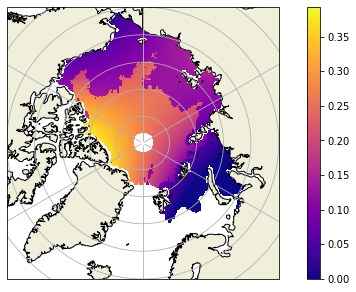

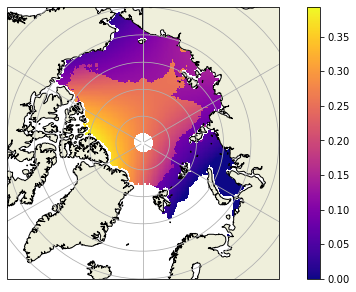

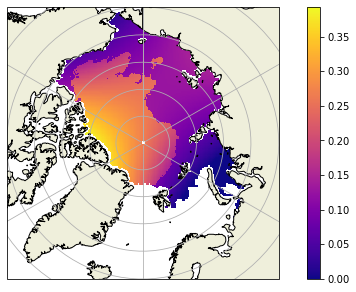

In [38]:
month = '12'


years = np.arange(2003,2006)

for year in years:
    snow_depth = get_field('mW99',month=month,year=year,resolution=361,variable='depth')['field']
    snow_depth = ma.masked_where(snow_depth < 0, snow_depth)

    snow_depth = select_region('basin',snow_depth)
    cartoplot(np.array(mask.get('lon')), np.array(mask.get('lat')),snow_depth)

[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
2011 01


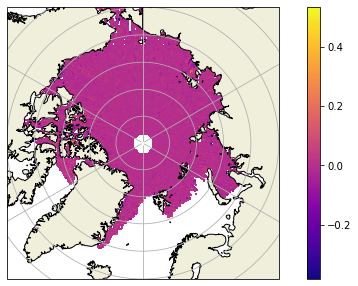

2011 02


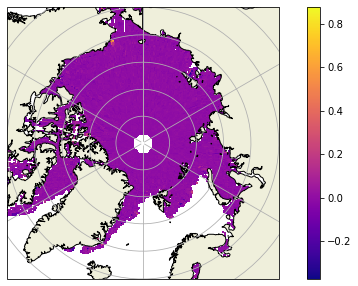

2011 03


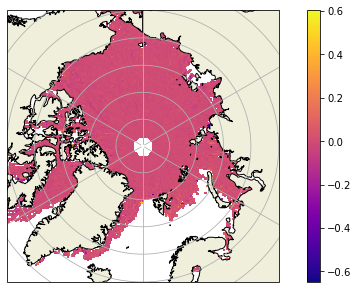

2011 04


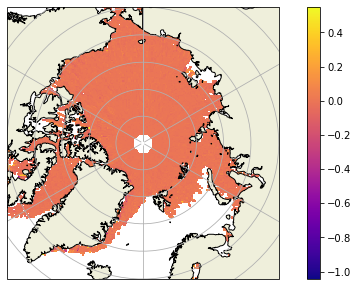

2011 10


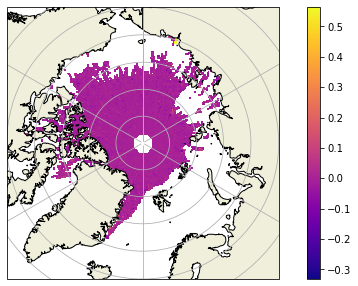

2011 11


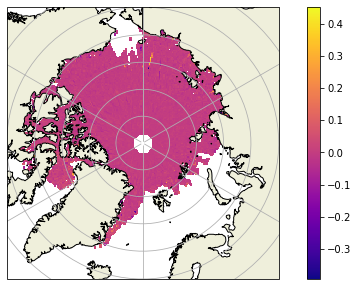

2011 12


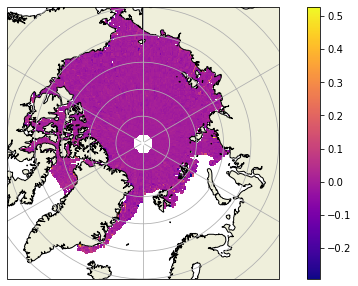

2012 01


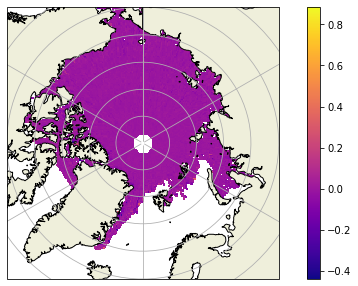

2012 02


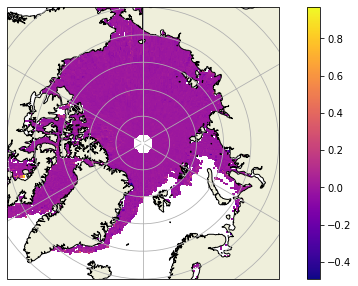

2012 03


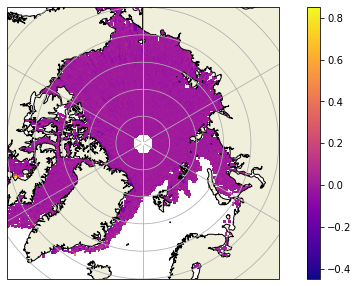

2012 04


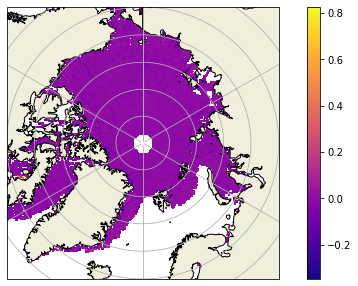

2012 10


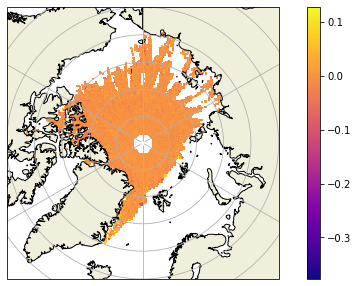

2012 11


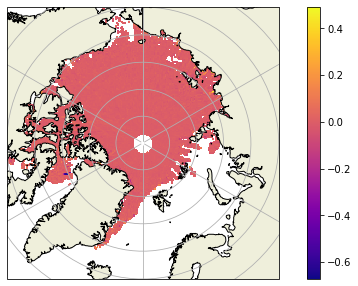

2012 12


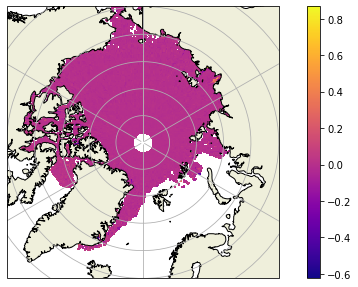

2013 01


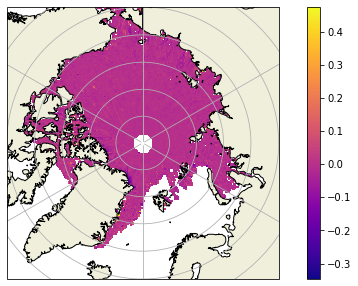

2013 02


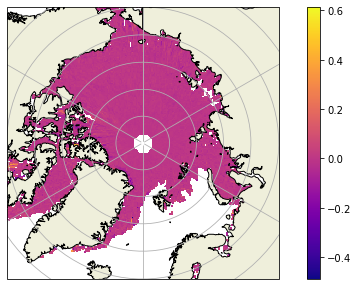

2013 03


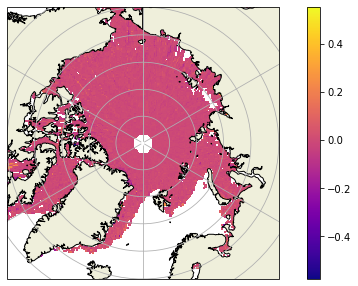

2013 04


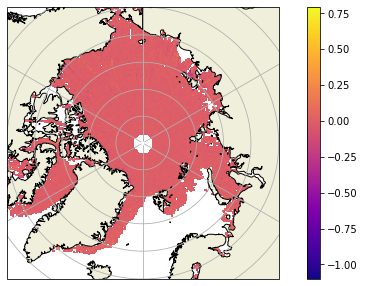

2013 10


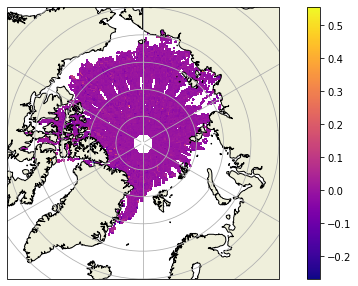

2013 11


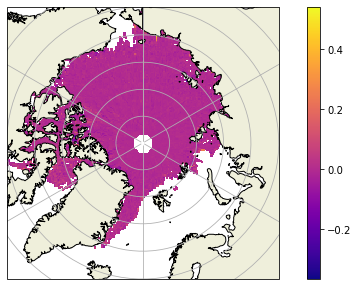

2013 12


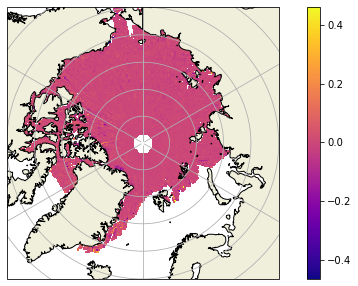

2014 01


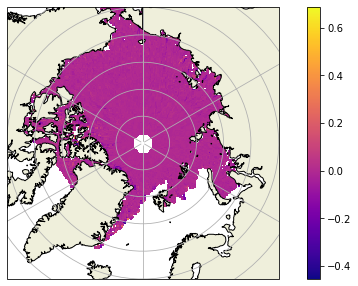

2014 02


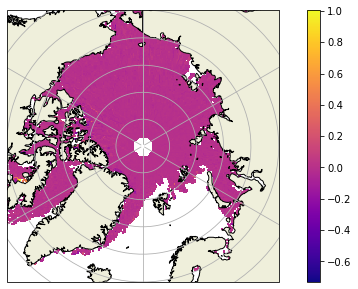

2014 03


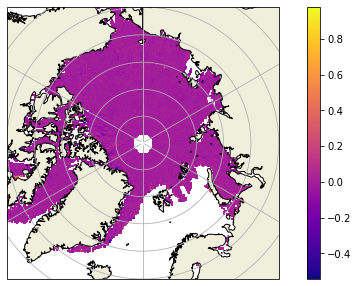

2014 04


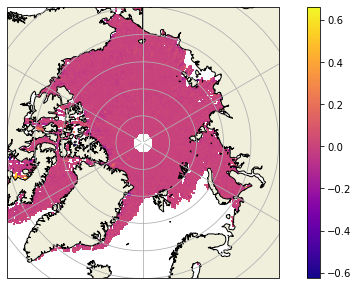

2014 10


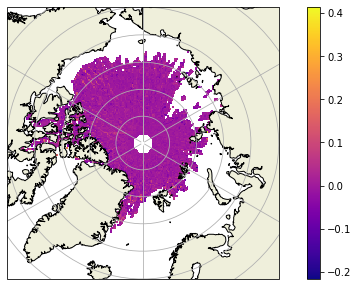

2014 11


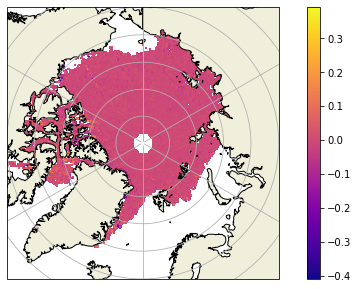

2014 12


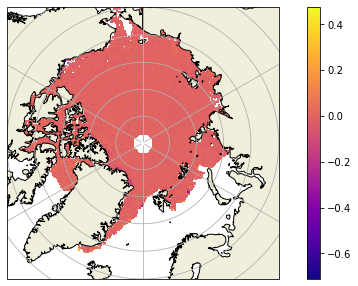

2015 01


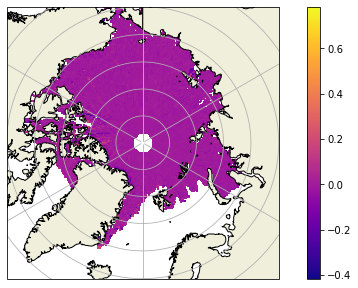

2015 02


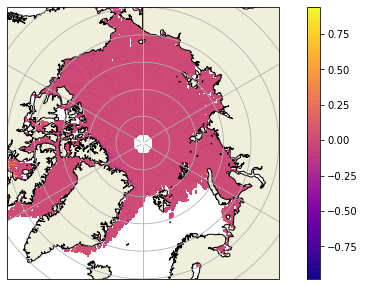

2015 03


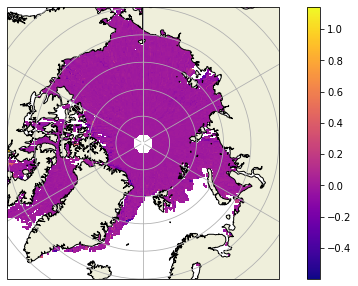

2015 04


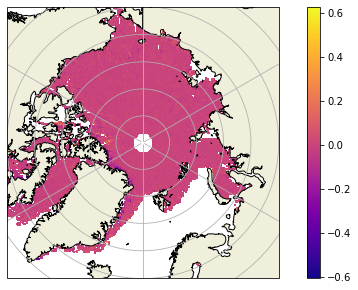

2015 10


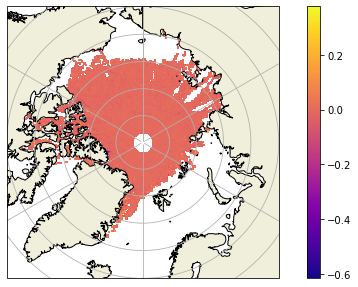

2015 11


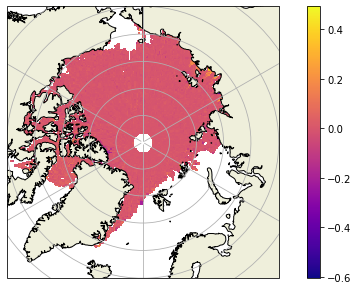

2015 12


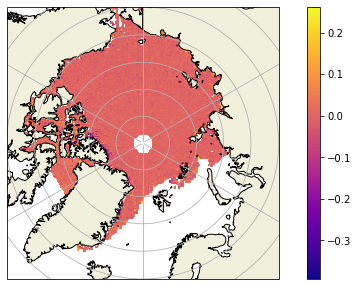

2016 01


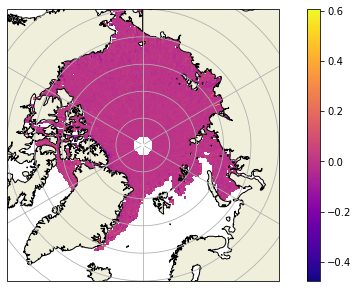

2016 02


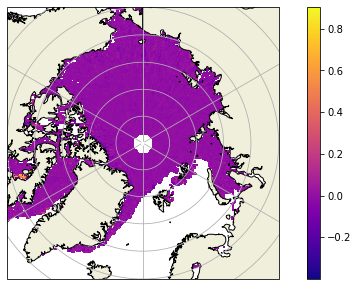

2016 03


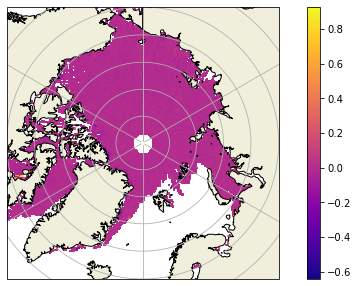

2016 04


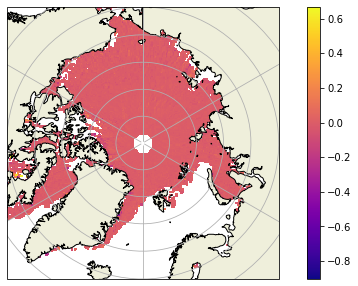

2016 10


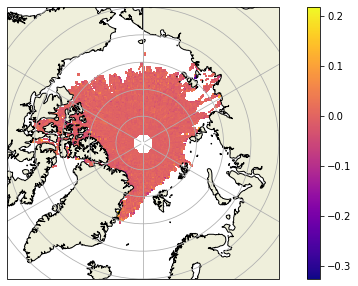

2016 11


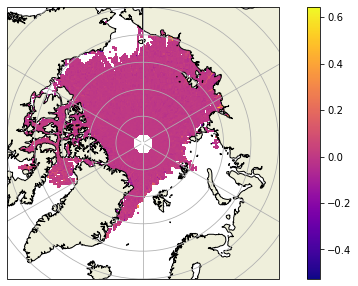

2016 12


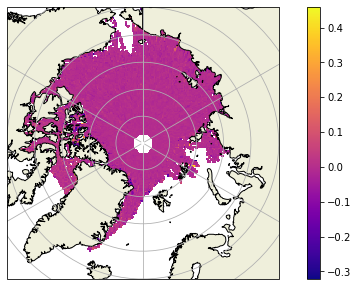

2017 01


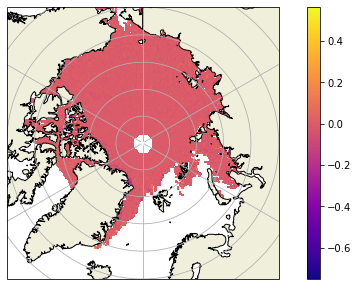

2017 02


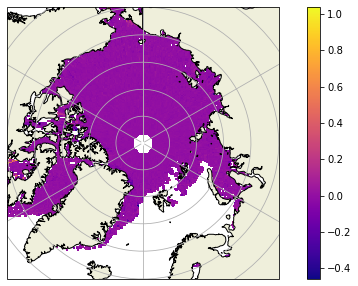

2017 03


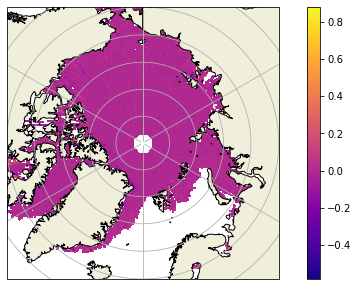

2017 04


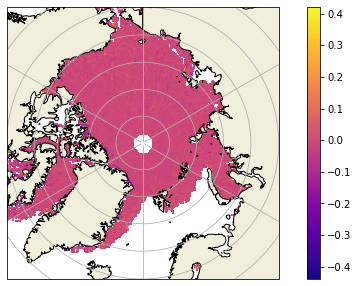

2017 10


FileNotFoundError: [Errno 2] No such file or directory: b'/home/robbie/Dropbox/SM_Thickness/data/CS2_CCI/2017/ESACCI-SEAICE-L3C-SITHICK-SIRAL_CRYOSAT2-NH25KMEASE2-201710-fv2.0.nc'

In [3]:
year='2016'
month='03'

yearlist = list(range(2011,2019))
print(yearlist)

monthlist_full = ["01","02","03","04","10","11","12"]


def get_AWI_RF(year,month):
    awi_dir = '/home/robbie/Dropbox/SM_Thickness/data/AWI_CS2/'
    dat = Dataset(f'{awi_dir}awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-{year}{month}-fv2p3.nc')
    field = dat['radar_freeboard'][0]
    lon = dat['lon']
    lat = dat['lat']
    ret_dict = {'field':field,
                'lon':lon,
                'lat':lat}
    return ret_dict

for year in yearlist:
    for month in monthlist_full:
        
        print(year,month)
        
        AWI = get_field('awi_cs2',month,year,resolution=444,variable='rad')
        CCI = get_field('cci_cs2',month,year,resolution=444,variable='rad')

        diff = AWI['field'] - CCI['field']

        cartoplot(AWI['lon'],AWI['lat'],diff)

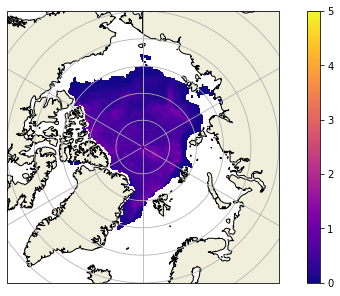

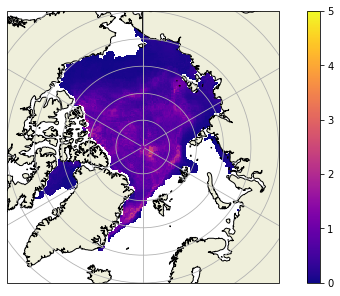

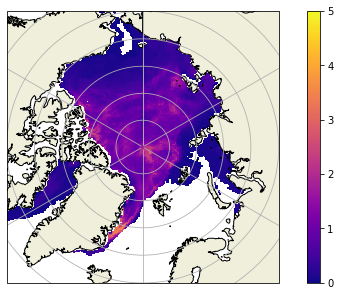

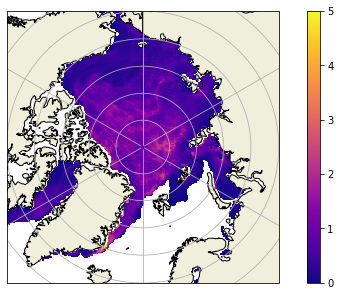

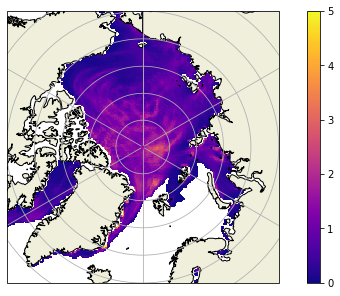

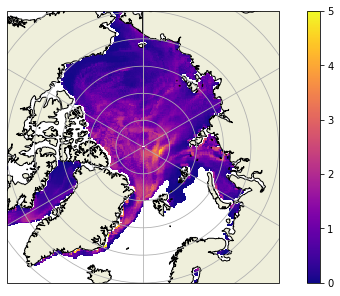

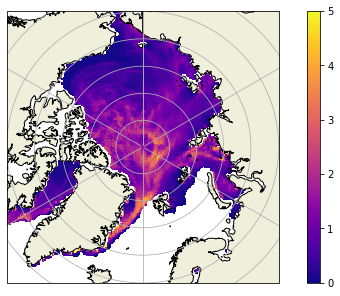

In [2]:
monthlist = ["10","11","12","01","02","03","04"]
year = 2016

dataset = 'SM'

for month in monthlist:
    
    data_dir = '/home/robbie/Dropbox/SM_Thickness/data/Components/'

    with xr.open_dataset(f'{data_dir}{year}_components.nc') as data:

        ds_month = data.where(int(month) == data.month, drop=True)

    d = np.array(ds_month[dataset])[0]
    
    cartoplot(mask.get('lon'), mask.get('lat'), d, color_scale = (0,5))

# Test the dataset

In [ ]:
from regrid import regrid
from mask import select_region

lon = mask.get('lon')
lat = mask.get('lat')

# d = get_field('cci_envisat', month='11',year=2009,variable='rad')
# fb = d['field']
# lon = d['lon']
# lat = d['lat']
data_dir = '/home/robbie/Dropbox/SM_Thickness/data/Components/'

with xr.open_dataset(f'{data_dir}2009_components.nc') as data:

    ds_month = data.where(int(11) == data.month, drop=True)

fb = np.array(ds_month['free'])[0]

fb_barents = select_region('Barents',fb)


cartoplot(lon,lat,fb_barents)

# cartoplot(lon,lat,fb_barents)

# print(np.nanmean(fb_barents))


# print(clean_fb_array)

# Calculate Offsets for W99

# Now test the W99 correction

In [ ]:
year = 2011

full_data = pickle.load(open("/home/robbie/Dropbox/GRL_Thickness/Corrections/"+str(year)+"_W99_corr.p","rb"))

fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='npstere',boundinglat=60,lon_0=360,resolution='l')
m.drawcoastlines(linewidth=0.5)

m.pcolormesh(Mask.get('lon'), Mask.get('lat'), full_data['03']['total_correction'], latlon=True,cmap='plasma')

plt.show()

# Finally, calculate the thickness difference between products

# Set the convention that differences are SM - W99

In [ ]:
for year in yearlist:
    
    print(year)
    
    year_data = {}
    
    if year == 2010:
        monthlist = monthlist_2010
    elif year == 2018:
        monthlist = monthlist_2018
    else:
        monthlist = monthlist_full
    
    for month in monthlist:
        
        mW99_data = pickle.load(open("../data/snow_components/"+month+str(year)+"mW99_snow_comp.p","rb"))
    
        SM_data = pickle.load(open("../data/snow_components/"+month+str(year)+"av_snow_comp.p","rb"))
        
        
        impact = SM_data - mW99_data
    
        pickle_out = open("../data/thickness_impact_fields/"+month+str(year)+"SM-mW99_thickness_impact.p","wb")
        pickle.dump(impact, pickle_out)
        
#         fig = plt.figure(figsize=(10, 8))

#         m = Basemap(projection='npstere',boundinglat=60,lon_0=360,resolution='l')
#         m.drawcoastlines(linewidth=0.5)

#         m.pcolormesh(Mask.get('lon'), Mask.get('lat'), corr_diff, latlon=True,cmap='RdBu',vmax=1,vmin=-1)

#         plt.colorbar()
        
#         plt.show()

# Test the correction difference dataset

In [ ]:
year = 2011

full_data = pickle.load(open("../data/thickness_impact_fields/"+"102015SM-mW99_thickness_impact.p","rb"))

print(full_data.shape)
print(Mask.get('lon').shape)

fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='npstere',boundinglat=60,lon_0=360,resolution='l')
m.drawcoastlines(linewidth=0.5)

m.pcolormesh(Mask.get('lon'), Mask.get('lat'), full_data, latlon=True,cmap='RdBu_r')

plt.show()

# Now calculate volume difference in each cell

In [ ]:
year = "2012"
month = "02"

correction_data[month] = pickle.load(open("/home/robbie/Dropbox/GRL_Thickness/Corrections/"+str(year)+"_corr_diff.p","rb"))

concentration_data = pickle.load(open("/media/robbie/Seagate Portable Drive/Concentration/" + month + str(year) + "_361x361.p","rb"))

mask_data = Mask.get('mask')

In [ ]:
d = Dataset('/home/robbie/Dropbox/SM_Thickness/data/Components/2012_components.nc')
d

In [ ]:
cartoplot(d['lon'],d['lat'],d['NS'][1][:,:])
cartoplot(d['lon'],d['lat'],d['type'][1][:,:])
cartoplot(d['lon'],d['lat'],d['SM'][1][:,:])